### Training loops

In [1]:
import tensorflow as tf


2023-09-01 12:36:33.296047: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 12:36:33.990598: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 12:36:33.994690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 12:36:37.969312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


 create some example data. This generates a cloud of points that loosely follows a quadratic curve

In [2]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]


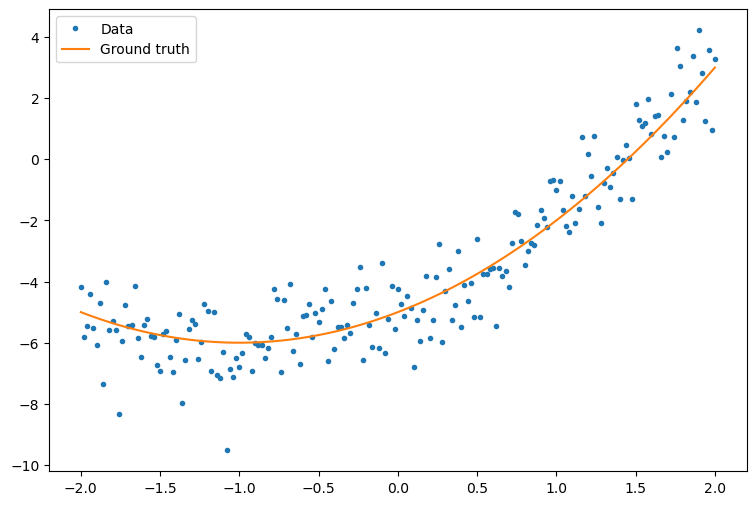

In [3]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend();


Create a quadratic model with randomly initialized weights and a bias

In [10]:
class Model(tf.Module):

  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])

  @tf.function
  def __call__(self, x):
    # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
    return self.w_q * (x**2) + self.w_l * x + self.b

Performance before trainingº

In [11]:
quad_model = Model()


In [12]:
def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()


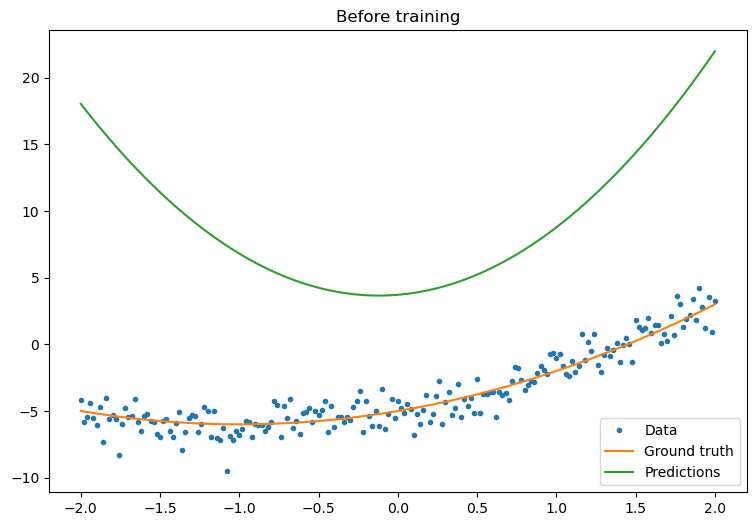

In [13]:
plot_preds(x, y, f, quad_model, 'Before training')


define a loss for your model
mean squared error (MSE)
$$ MSE= \frac{1}{m}\sum_{i=1}^{m}(\hat{y}_i-y_i)^2 $$

In [14]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))


basic training loop for the model

The loop will make use of the MSE loss function and its gradients with respect to the input in order to iteratively update the model's parameters. Using mini-batches for training provides both memory efficiency and faster convergence. The tf.data.Dataset API has useful functions for batching and shuffling


In [15]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size)


Mean squared error for step 0: 72.467
Mean squared error for step 10: 5.942
Mean squared error for step 20: 2.639
Mean squared error for step 30: 1.501
Mean squared error for step 40: 1.097
Mean squared error for step 50: 0.954
Mean squared error for step 60: 0.904
Mean squared error for step 70: 0.886
Mean squared error for step 80: 0.879
Mean squared error for step 90: 0.877




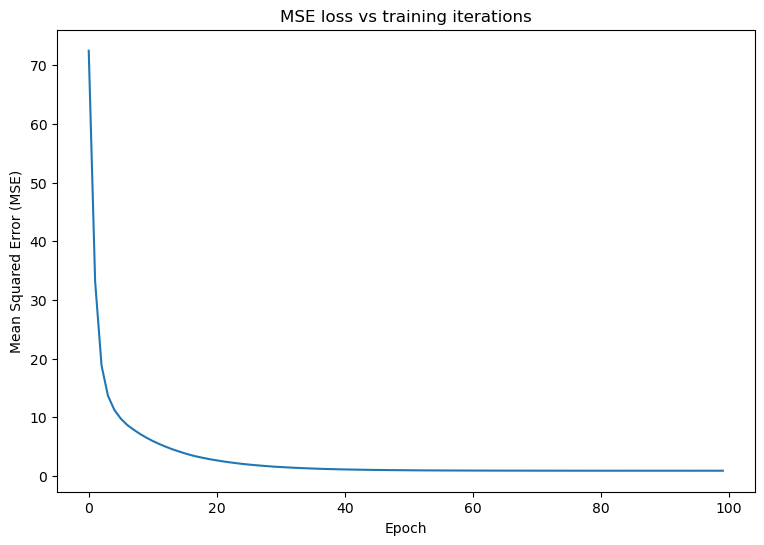

In [16]:
# Set training parameters
epochs = 100
learning_rate = 0.01
losses = []

# Format training loop
for epoch in range(epochs):
  for x_batch, y_batch in dataset:
    with tf.GradientTape() as tape:
      batch_loss = mse_loss(quad_model(x_batch), y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, quad_model.variables)
    for g,v in zip(grads, quad_model.variables):
        v.assign_sub(learning_rate*g)
  # Keep track of model loss per epoch
  loss = mse_loss(quad_model(x), y)
  losses.append(loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');


observe your model's performance after training:

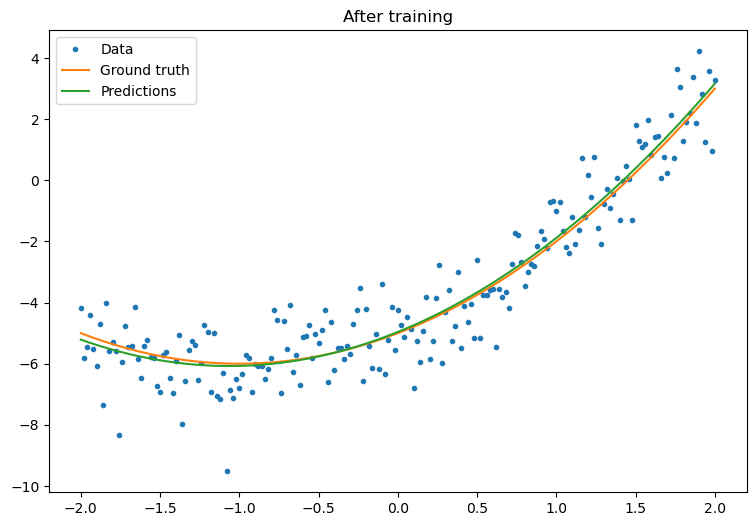

In [17]:
plot_preds(x, y, f, quad_model, 'After training')


That's working, but remember that implementations of common training utilities are available in the tf.keras module. So, consider using those before writing your own. To start with, the Model.compile and Model.fit methods implement a training loop for you

Begin by creating a Sequential Model in Keras using tf.keras.Sequential. One of the simplest Keras layers is the dense layer, which can be instantiated with tf.keras.layers.Dense. The dense layer is able to learn multidimensional linear relationships of the form $$ \mathrm{Y} = \mathrm{W}\mathrm{X} +  \vec{b} $$
In order to learn a nonlinear equation of the form, $ w_1x^2 + w_2x+b$
the dense layer's input should be a data matrix with $x^2$ and $ x $ as features.
The lambda layer, tf.keras.layers.Lambda, can be used to perform this stacking transformation.

In [18]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)])


In [20]:
new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)
# new_model.save('./my_new_model')


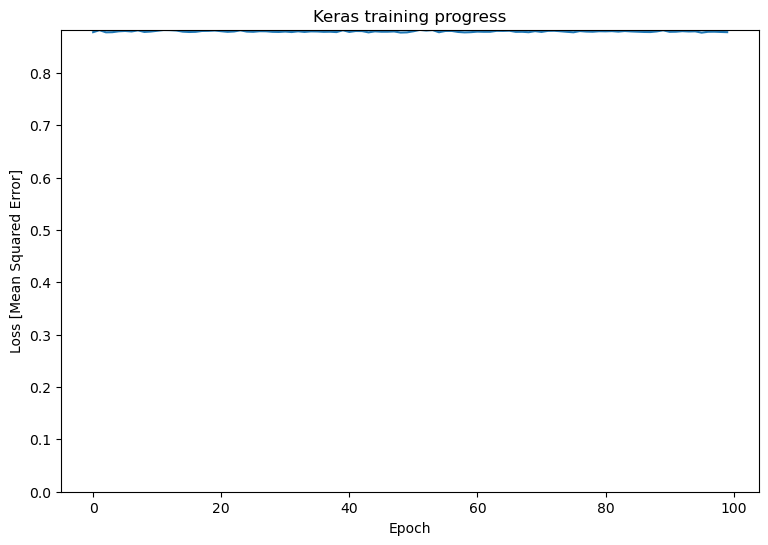

In [21]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');


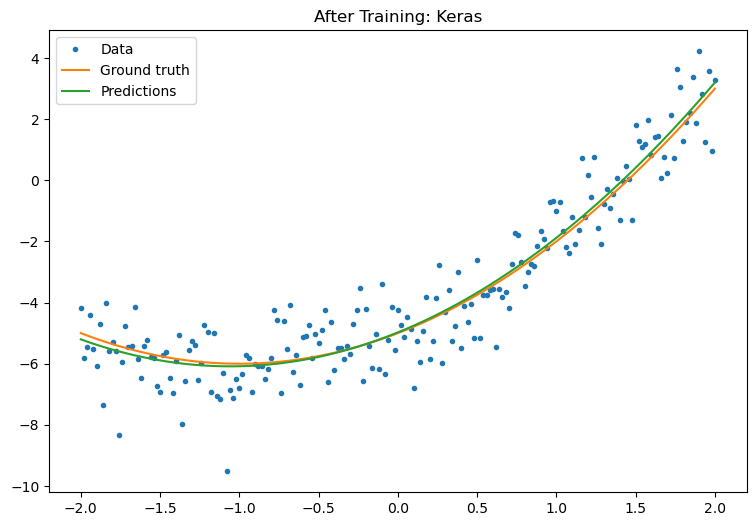

In [22]:
plot_preds(x, y, f, new_model, 'After Training: Keras')
